# Class Activation Map
The class activation map is an approach to visualize and get insights from a Convolutional Neural Network. With the application of this approach, a heatmap of "Class Activation" over the input image is generated. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for every location in the input image, indicating how important each location is with respect to the class considered. In this code, Keras is used to apply the class activation map on x-ray images to localize the areas of the radiograph which the model predicts to be most indicative of each observation with Gradient-weighted Class Activation Mappings (GradCAMs). See image below for  schemtic view of how this weighted gradient is applied on the image. 

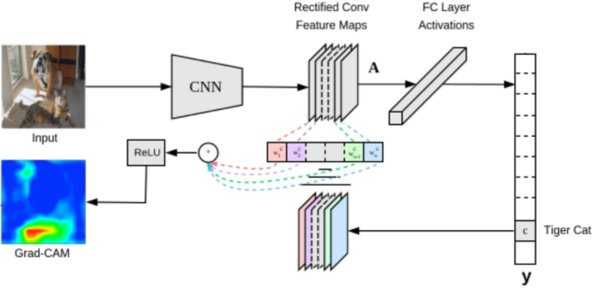

I found the following sources very helpful to code this section for my application:

Reference link-1: https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

Reference link-2: https://www.kaggle.com/ibtesama/pneumonia-detection-fine-tuning-and-cam/log

In [2]:
import numpy as np
import keras
from keras.models import Model
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from PIL import Image
%matplotlib inline
K.clear_session()

Using TensorFlow backend.


Load the Densenet121 model I trained on CheXpert data before

In [3]:
model = load_model('model_DenseNet121_Full_Sample.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Select a patient's x-ray image from test set and check prediction

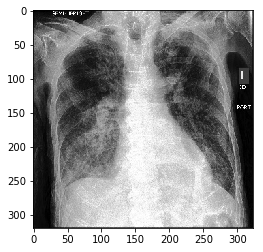

In [4]:
fname = '/home/ubuntu/cs230Project/CheXpert-v1.0-small/valid/patient64555/study1/view1_frontal.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

In [5]:
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
target_size = (224,224)
dvalid_set=pd.read_csv("CheXpert-v1.0-small/valid.csv")
dvalid_set = dvalid_set.fillna(0)
dvalid_set = dvalid_set[~dvalid_set[dvalid_set.columns[3]].str.contains("Lateral")]
dvalid_set= dvalid_set.drop(["Sex", "Age", "Frontal/Lateral", "AP/PA"], axis=1)
dvalid_set = dvalid_set.replace(-1,1)
valid_datagen=ImageDataGenerator(rescale=1./255.)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dvalid_set, directory=None, x_col="Path", y_col=list(dvalid_set.columns[1:15]), class_mode="other", drop_duplicates = False, target_size=target_size, shuffle = False, batch_size=1)

Found 202 images.


In [7]:
# image for the sampled patient above
index=15 # this is for the selected patient above
print(valid_generator[index])

(array([[[[0.03529412, 0.03529412, 0.03529412],
         [0.02352941, 0.02352941, 0.02352941],
         [0.03137255, 0.03137255, 0.03137255],
         ...,
         [0.9803922 , 0.9803922 , 0.9803922 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.37254903, 0.37254903, 0.37254903]],

        [[0.01176471, 0.01176471, 0.01176471],
         [0.01568628, 0.01568628, 0.01568628],
         [0.01960784, 0.01960784, 0.01960784],
         ...,
         [0.92549026, 0.92549026, 0.92549026],
         [1.        , 1.        , 1.        ],
         [0.4039216 , 0.4039216 , 0.4039216 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.03529412, 0.03529412, 0.03529412],
         [0.04705883, 0.04705883, 0.04705883],
         ...,
         [0.9215687 , 0.9215687 , 0.9215687 ],
         [0.9921569 , 0.9921569 , 0.9921569 ],
         [0.36078432, 0.36078432, 0.36078432]],

        ...,

        [[0.10196079, 0.10196079, 0.10196079],
         [0.07843138, 0.07843138, 0.07843138

In [8]:
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
valid_generator.reset()
pred=model.predict_generator(valid_generator, steps=STEP_SIZE_VALID)
pred_bool = (pred >= 0.5)
y_pred = np.array(pred_bool,dtype =int)

dvalid = dvalid_set.to_numpy()
y_true = np.array(dvalid[:,1:15],dtype=int)


In [9]:
print(y_true[index])
print(y_pred[index])

[0 0 0 1 0 1 1 0 1 0 0 0 0 0]
[0 0 0 1 0 1 1 0 0 0 0 0 0 0]


Review the model and get the last convolution layer features

In [10]:
#print(model.summary())

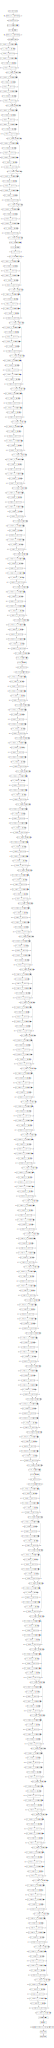

In [71]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model

def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
visualize_model(model)

In [11]:
last_conv_layer = model.get_layer('relu')
print(last_conv_layer)

In [12]:
# The highest predicted probability observation is consolidation
argmax = np.argmax(pred[index])
print(pred[index])
print(argmax)

[4.7294497e-03 7.9202652e-04 1.8246293e-02 7.8325164e-01 2.0266235e-02
 7.3802459e-01 8.2783228e-01 4.8393774e-01 2.4939418e-01 3.4022033e-03
 2.7116644e-01 1.2964010e-05 2.6668737e-05 6.9646952e-03]
6


Compute heatmap with the weighted gradient class application map

In [13]:
output = model.output[:, argmax]

In [14]:
grads = K.gradients(output, last_conv_layer.output)[0]

In [15]:
print(grads)

Tensor("gradients/global_average_pooling2d_1/Mean_grad/truediv:0", shape=(?, ?, ?, 1024), dtype=float32)


In [16]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [17]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [18]:
x=valid_generator[index][0]
pooled_grads_value, conv_layer_output_value = iterate([x])

In [19]:
for i in range(1024):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

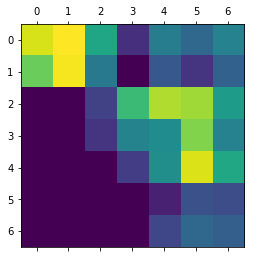

In [20]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [22]:
import cv2
# select the sample and read the corresponding image and label
sample_image = cv2.imread(fname)
# pre-process the image
sample_image = cv2.resize(sample_image, (224,224))
if sample_image.shape[2] ==1:
            sample_image = np.dstack([sample_image, sample_image, sample_image])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = sample_image.astype(np.float32)/255.
sample_label = 1

In [23]:
sample_image_processed = np.expand_dims(sample_image, axis=0)

In [24]:
sample_image_processed.shape

(1, 224, 224, 3)

In [25]:
heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
heatmap = heatmap *255
heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [26]:
from skimage import data, color, io, img_as_float
sample_image_hsv = color.rgb2hsv(sample_image)
heatmap = color.rgb2hsv(heatmap)

In [27]:
alpha=0.7
sample_image_hsv[..., 0] = heatmap[..., 0]
sample_image_hsv[..., 1] = heatmap[..., 1] * alpha

In [28]:
img_masked = color.hsv2rgb(sample_image_hsv)

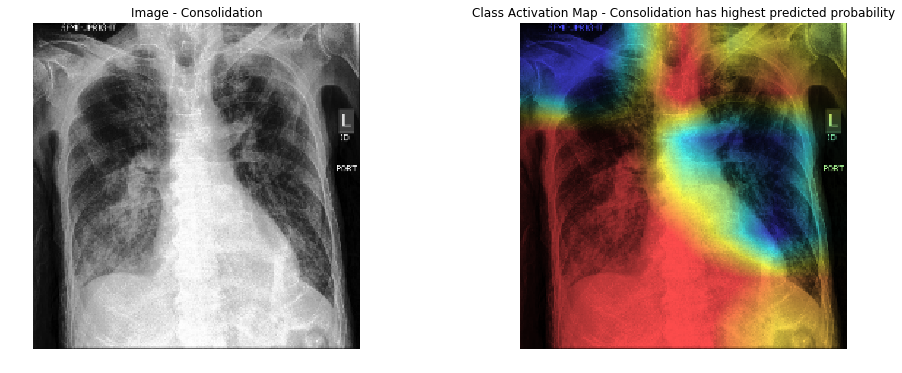

In [31]:
f,ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(sample_image)
ax[0].set_title(f"Image - Consolidation")
ax[0].axis('off')
    
ax[1].imshow(img_masked)
ax[1].set_title("Class Activation Map - Consolidation has highest predicted probability")
ax[1].axis('off')

plt.show()